In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, size, avg, explode, regexp_replace, when, collect_list, expr, udf
# from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, FloatType
from sentence_transformers import SentenceTransformer
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import numpy as np
from scipy.spatial.distance import cosine
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import beta
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from matplotlib import cm
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.functions import array_to_vector
from pyspark.ml.linalg import Vectors
from pyspark.sql.window import Window

In [0]:
N = 20000
seed = 42
k = 10
# Change this to test a different model
index_model = 0

# Due to technical issues, the actual dataset for DistilBERT was indexed as number 3
models_list = ['BERT',
                'RoBERTa',
                'DistilBERT',
                'DistilBERT']

model_name = models_list[index_model]

spark.conf.set("spark.sql.execution.rangeExchange.sampleRate", str(seed))

In [0]:
people_name =  f'people_new_misc_model_index_{index_model}_N_{N}'
matchings_name = f'job_listings_most_compatible_people_K_{k}_N_{N}_model_{index_model}'

In [0]:
meta_industries = ['Healthcare and Medical', 'Media and Entertainment', 'Technology', 'Government and Public Policy', 'Real Estate and Construction', 'Financial and Investment', 'Transportation and Logistics', 'Services', 'Education and Training', 'Manufacturing', 'Retail and Consumer Goods', 'Miscellaneous']

people_transformed = spark.read.format("parquet").load(f"dbfs:/FileStore/tables/dvirPeleg/{people_name}")
matchings = spark.read.parquet(f"dbfs:/FileStore/tables/dvirPeleg/{matchings_name}")

In [0]:
people_transformed = people_transformed.select('id', 'meta_industry', 'title_vector')
matchings = matchings.select('job_id', 'meta_industry', 'only_title_emb', 'most_compatible')

In [0]:
meta_industry_workers = {
    industry: people_transformed.filter(people_transformed["meta_industry"] == industry).cache()
    for industry in meta_industries
}

In [0]:
# meta_industry_counts = {
#     industry: df.count() for industry, df in meta_industry_workers.items()
# }

# for industry, count in meta_industry_counts.items():
#     print(f"{industry}: {count} rows")

In [0]:
meta_industry_samples = {
    industry: df.orderBy(F.rand(seed=seed)).limit(k).cache()
    for industry, df in meta_industry_workers.items()
}

In [0]:
def cosine_similarity(v1, v2):
    """
    Computes the cosine similarity between two vectors.
    @param v1: The first vector
    @param v2: The second vector
    @return: The cosine similarity between the two vectors
    """
    v1 = np.array(v1)
    v2 = np.array(v2)
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return float(dot_product / (norm_v1 * norm_v2)) if norm_v1 != 0 and norm_v2 != 0 else 0.0

cosine_similarity_udf = udf(cosine_similarity, FloatType())

In [0]:
# Combine all dataframes in meta_industry_samples into one dataframe
combined_samples_df = None
for meta_industry, samples_df in meta_industry_samples.items():
    samples_df = samples_df.withColumn("meta_industry", F.lit(meta_industry))
    if combined_samples_df is None:
        combined_samples_df = samples_df
    else:
        combined_samples_df = combined_samples_df.union(samples_df)

combined_samples_df = combined_samples_df.cache()

In [0]:
# Join matchings with combined_samples_df on meta_industry
joined_df = matchings.join(
    combined_samples_df,
    on="meta_industry",
    how="inner"
)

# Calculate cosine similarity for each pair
similarity_df = joined_df.withColumn(
    "similarity",
    cosine_similarity_udf(F.col("only_title_emb"), F.col("title_vector"))
)

# Group by job_id and calculate the average similarity
average_similarity_df = similarity_df.groupBy("job_id").agg(
    avg("similarity").alias("average_similarity_baseline")
)

# Join the average similarity back to the original matchings dataframe
matchings = matchings.join(
    average_similarity_df,
    on="job_id",
    how="left"
)

In [0]:
# Explode the most_compatible list so that each ID gets its own row
matchings_exploded = matchings.withColumn("id", F.explode("most_compatible"))

# Join with people_transformed on the id column
joined_df = matchings_exploded.join(people_transformed, on="id", how="left")

# Compute cosine similarity between only_title_emb and title_vec
joined_df = joined_df.withColumn("similarity", cosine_similarity_udf("only_title_emb", "title_vector"))

# Aggregate to compute the average similarity per job_id
average_similarity_df = joined_df.groupBy("job_id").agg(F.avg("similarity").alias("average_similarity_most_compatible"))

# Join the average similarity back to the original matchings dataframe
matchings = matchings.join(average_similarity_df, on="job_id", how="left")

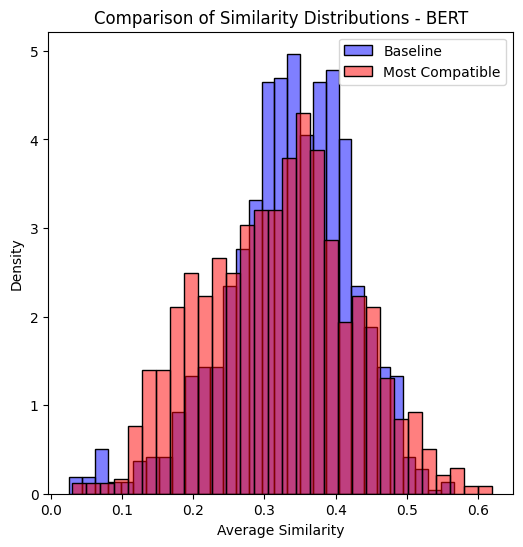

In [0]:
# Convert Spark DataFrame to Pandas DataFrame
pdf = matchings.toPandas()

# Generate values for plotting the beta distribution
x = np.linspace(0, 1, 100)

# Plot histograms
plt.figure(figsize=(6, 6))
sns.histplot(pdf['average_similarity_baseline'], bins=30, kde=False, color='blue', label='Baseline', alpha=0.5, stat='density')
sns.histplot(pdf['average_similarity_most_compatible'], bins=30, kde=False, color='red', label='Most Compatible', alpha=0.5, stat='density')

# Labels and title
plt.xlabel('Average Similarity')
plt.ylabel('Density')
plt.title(f'Comparison of Similarity Distributions - {model_name}')
plt.legend()

# Show plot
plt.show()

In [0]:
# Hypothesis Testing
# For each meta industry
# - Null Hypothesis: The average similarity of the most compatible is equal to the average similarity of the baseline
# - Alternative Hypothesis: The average similarity of the most compatible is greater than the average similarity of the baseline

meta_industries = pdf["meta_industry"].unique()  # Get unique meta_industries

p_values = {}
for industry in meta_industries:
    subset = pdf[pdf["meta_industry"] == industry]
    
    t_stat, p_value = stats.ttest_ind(
        subset["average_similarity_most_compatible"], 
        subset["average_similarity_baseline"],
        alternative='greater'  # One-sided test for greater mean
    )
    
    # Assign significance levels
    if p_value < 0.001:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.05:
        significance = "*"
    else:
        significance = ""
    
    p_values[industry] = f"{p_value:.2e} {significance}"

print(model_name)

max_length = max(len(industry) for industry in p_values.keys())

# Print results in aligned format
for industry, formatted_p_value in p_values.items():
    print(f"{industry.ljust(max_length)} - {formatted_p_value}")

BERT
Financial and Investment     - 4.58e-01 
Education and Training       - 1.00e+00 
Healthcare and Medical       - 1.00e+00 
Transportation and Logistics - 3.91e-01 
Real Estate and Construction - 9.64e-01 
Government and Public Policy - 9.77e-01 
Manufacturing                - 5.65e-02 
Media and Entertainment      - 9.28e-12 ***
Miscellaneous                - 7.65e-03 **
Retail and Consumer Goods    - 1.00e+00 
Technology                   - 1.00e+00 
Services                     - 7.49e-01 
